# Proyecto Minería de Datos grupo 13

Integrantes:
- 

In [4]:
# Primero importamos las librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuramos matplotlib para mostrar gráficos en el notebook
%matplotlib inline

In [22]:
# Cargamos los datos
def cargar_datos():
    
    df_anime = pd.read_csv('animes.csv', encoding="UTF-8", 
                          usecols=['animeID', 'type', 'year', 'episodes', 'score', 'genres'])
    #df_rating = pd.read_csv('ratings.csv', encoding="UTF-8",usecols=['animeID', 'rating', 'userID'])
    
    print(f"Animes cargados: {len(df_anime)} registros")
    print(f"Ratings cargados: {len(df_rating)} registros")
    
    return df_anime, #df_rating

df_anime = cargar_datos()

Animes cargados: 20237 registros
Ratings cargados: 148170496 registros


In [20]:
print(df_anime.head())
print()
#print(df_rating.head())

   animeID   type  year score  episodes  \
0        1  MOVIE  2004  8.41         1   
1        2     TV  2006  8.63        37   
2        3     TV  2013  7.42        10   
3        4     TV  2012  7.34        12   
4        5     TV  2012   7.5        25   

                                              genres  
0  ['Adventure', 'Award Winning', 'Drama', 'Fanta...  
1                       ['Supernatural', 'Suspense']  
2                    ['Action', 'Comedy', 'Fantasy']  
3                   ['Action', 'Sci-Fi', 'Suspense']  
4      ['Action', 'Adventure', 'Fantasy', 'Romance']  

   userID  animeID  rating
0       1        1      10
1       1        2      10
2       1        3       7
3       1        4      10
4       1        5      10


## Exploración de los datos

In [6]:
#1. Tamaño de los datasets

#Primero con el tamaño de animes
print("Tamaño del dataset de animes", df_anime.shape)

# Ahora con el tamaño de ratings
print("Tamaño del dataset de ratings", df_rating.shape)

Tamaño del dataset de animes (20237, 7)
Tamaño del dataset de ratings (148170496, 2)


In [7]:
#2. Veamos si existen valores nulos

# Valores nulos en animes
print("Valores nulos en el dataset de animes")
print(df_anime.isnull().sum())

# Valores nulos en ratings
print("Valores nulos en el dataset de ratings")
print(df_rating.isnull().sum())

Valores nulos en el dataset de animes
animeID     0
title       0
type        0
year        0
score       0
episodes    0
genres      0
dtype: int64
Valores nulos en el dataset de ratings
animeID    0
rating     0
dtype: int64


Podemos ver que en los datos más relevantes de ambos datasets no contienen valores nulos, exceptuando por la columna de títulos alternativos en el dataset de animes.

In [10]:
#3. Veamos la cantidad de valores únicos en ratings
print("\nUsuarios únicos en ratings:", df_rating['userID'].nunique())
print("Animes únicos en ratings:", df_rating['animeID'].nunique())
print("Número total de calificaciones:", len(df_rating))


Usuarios únicos en ratings: 1774522
Animes únicos en ratings: 20237
Número total de calificaciones: 148170496


## Visualizaciones

En esta sección realizamos distintas visualizaciones que podrían ser interesantes para nuestro proyecto

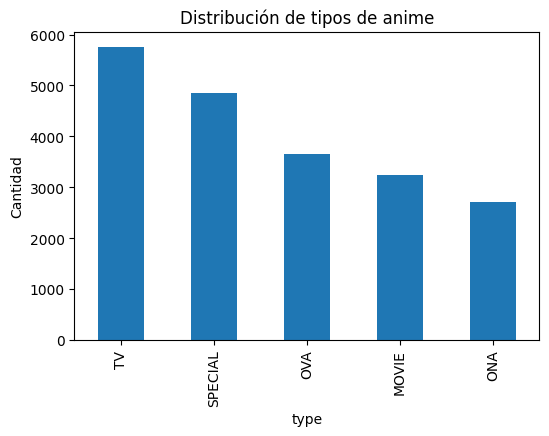

In [11]:
# Distribución de tipos de anime
plt.figure(figsize=(6,4))
df_anime['type'].value_counts().plot(kind='bar')
plt.title("Distribución de tipos de anime")
plt.ylabel("Cantidad")
plt.show()

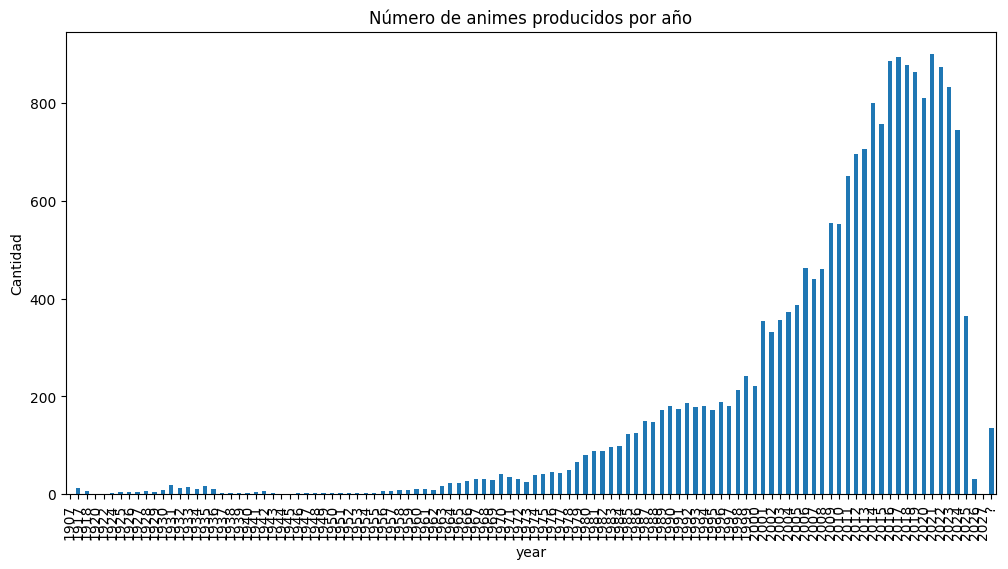

In [12]:
# Producción de animes por año
plt.figure(figsize=(12,6))

# Primero filtramos los animes desde 1956 debido a que los otros son más bien valores atípicos.
df_anime['year'].value_counts().sort_index().plot(kind='bar')
plt.title("Número de animes producidos por año")
plt.ylabel("Cantidad")
plt.show()

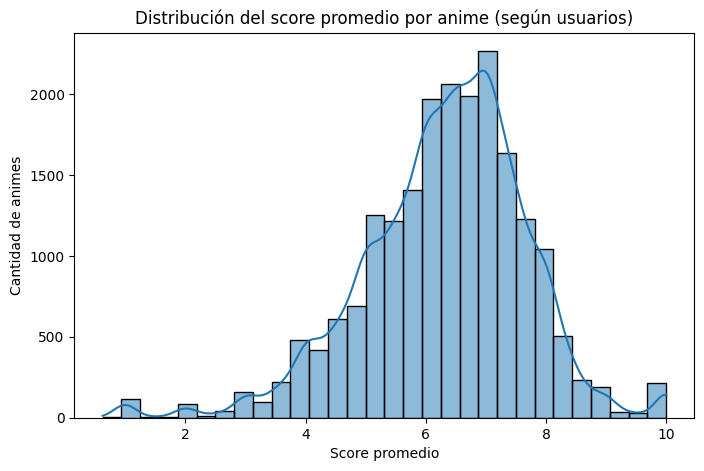

In [13]:
 # Calcular score promedio por anime (según ratings de usuarios) 
anime_avg_score = df_rating.groupby('animeID')['rating'].mean().reset_index()

# Merge para tener también el título
anime_avg_score = anime_avg_score.merge(df_anime[['animeID','title']], on='animeID', how='left')

# Visualización: distribución del score promedio
plt.figure(figsize=(8,5))
sns.histplot(anime_avg_score['rating'], bins=30, kde=True)
plt.title("Distribución del score promedio por anime (según usuarios)")
plt.xlabel("Score promedio")
plt.ylabel("Cantidad de animes")
plt.show()


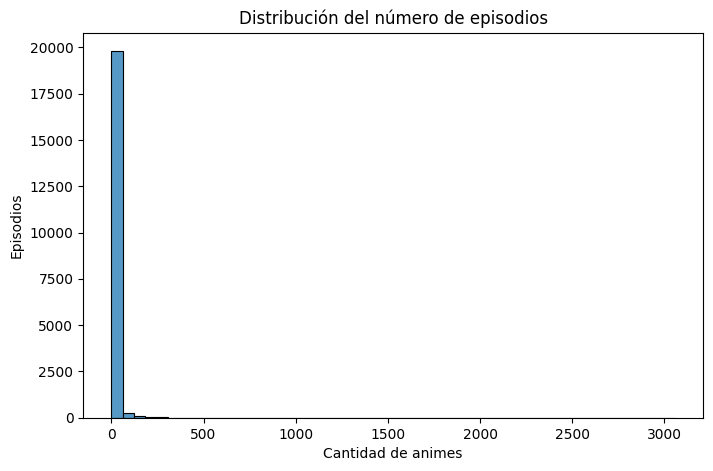

In [14]:
#  Distribución de episodios
plt.figure(figsize=(8,5))
sns.histplot(df_anime['episodes'].replace('Unknown', None).dropna().astype(int),
    bins=50
)
plt.title("Distribución del número de episodios")
plt.ylabel("Episodios")
plt.xlabel("Cantidad de animes")
plt.show()

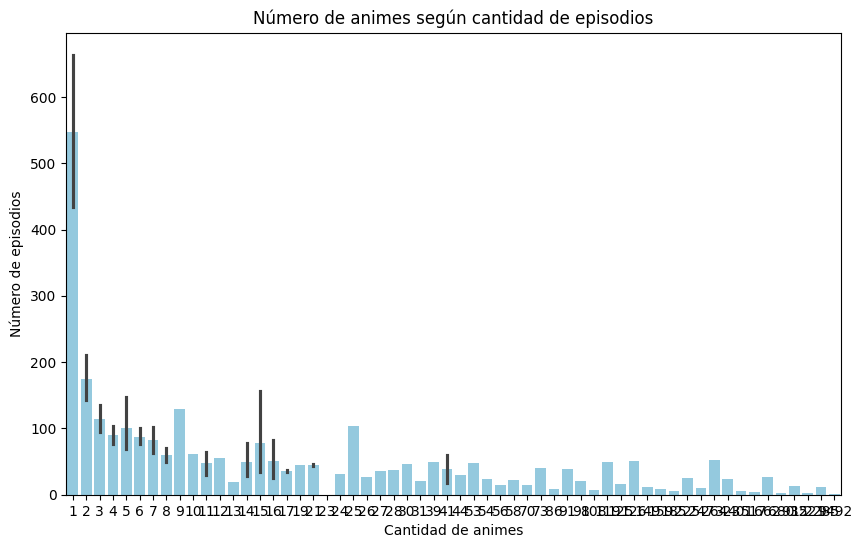

In [16]:
# Número de animes según cantidad de episodios

# limpiar columna episodes
episodes = pd.to_numeric(df_anime['episodes'].replace('Unknown', np.nan), errors='coerce').dropna().astype(int)

# contar cuántos animes hay por número de episodios
counts = episodes.value_counts().sort_index()

# gráfica de barras horizontal
plt.figure(figsize=(10,6))
sns.barplot(x=counts.values, y=counts.index, color="skyblue")

plt.xlabel("Cantidad de animes")
plt.ylabel("Número de episodios")
plt.title("Número de animes según cantidad de episodios")
plt.show()

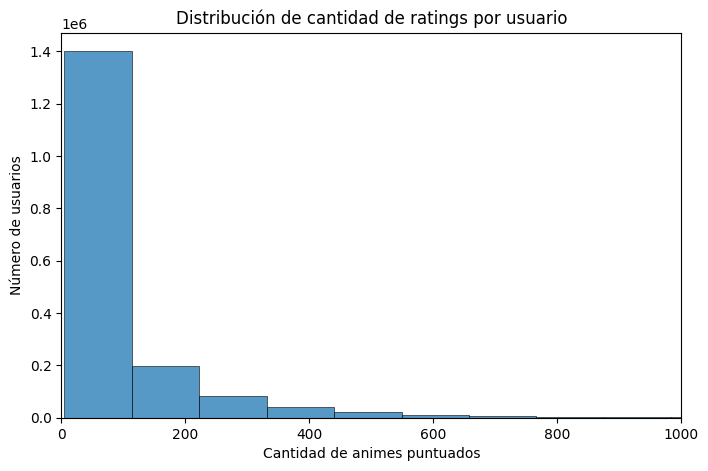

In [17]:
# Ratings por usuario
ratings_per_user = df_rating.groupby('userID').size()
plt.figure(figsize=(8,5))
sns.histplot(ratings_per_user, bins=100)
plt.title("Distribución de cantidad de ratings por usuario")
plt.xlabel("Cantidad de animes puntuados")
plt.ylabel("Número de usuarios")
plt.xlim(0, 1000)  
plt.show()

### Pregunta a resolver ###

¿El score puede predecirse con buena precisión usando solo un subconjunto pequeño de atributos? ¿Qué características son más importantes para explicar/predicir el score de un anime?

### Metodología a utilizar ###

Para responder esta pregunta, una vez aplicado el pre procesamiento adicional necesario, se utilizarán modelos de regresión supervisada. En primer lugar se emplearán modelos lineales: Regresión lineal, Lasso y Ridge, que evalúan directamente cuánto influye cada feature en la variable objetivo, en este caso, el Score Además, de Lasso realiza una selección automática de las variables relevantes.Posteriormente, se entrenarán modelos más robustos basados en árboles de decisión mediante métodos de ensamble como Random forest y Boosting, con el fin de capturar relaciones no lineales y evaluar si aportan mejoras significativas en el desempeño. La selección de características en los modelos lineales se realizará con Lasso y para los modelos de ensamble se hará mediante Permutation Importance, técnica que consiste en desordenar los valores de una variable y medir cómo afectan en el desempeño del modelo, de esta forma se identifican aquellas variables más importantes. Una vez obtenidas las variables relevantes, se comparará el desempeño de los modelos entrenados con todas las características frente a los entrenados con un conjunto reducido.

Para la evaluación de los resultados se utilizará validación cruzada de cinco folds, cuatro de entrenamiento y uno de prueba en cada iteración. Para ello se utilizarán las métricas de error medio absoluto, error cuadrático medio y el coeficiente R^2. Los resultados se compararán con un modelo baseline que predice simplemente la media del Score de todos los animes, y se analizará como varía el rendimiento de los modelos al usar todas las variables frente a un con un conjunto reducido de las más relevantes.

## Implementación de modelo para los primeros resultados

In [27]:
def preprocess_data(df_anime, df_rating):
    df = df_anime.copy()

    # Estadísticas de ratings
    rating_stats = df_rating.groupby('animeID').agg({
        'rating': ['count', 'mean', 'std']
    }).reset_index()
    rating_stats.columns = ['animeID', 'rating_count', 'rating_mean', 'rating_std']
    
    # Unir datasets
    df = df.merge(rating_stats, on='animeID', how='left')
    
    return df

df_processed = preprocess_data(df_anime, df_rating)

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ========================
# 0. Limpiar y preparar datos
# ========================
df = df_anime.copy()
df = df[df['score'] != '?']  # quitar '?' del score
df['score'] = df['score'].astype(float)
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Quitar filas con NA en las columnas importantes
df = df.dropna(subset=['episodes', 'year', 'score', 'type', 'genres'])

# ========================
# 1. Definir X y y
# ========================
y = df['score']
X = df[['type', 'genres', 'episodes', 'year']].copy()

# ColumnTransformer para codificar Type y Genres
preprocessor = ColumnTransformer(
    transformers=[
        ('type_enc', OneHotEncoder(handle_unknown='ignore'), ['type']),
        ('genres_enc', OneHotEncoder(handle_unknown='ignore'), ['genres']),
    ],
    remainder='passthrough'  # Episodes y Year quedan sin tocar
)

# ========================
# 2. Definir métricas
# ========================
scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    "R2": make_scorer(r2_score)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ========================
# 3. Baseline
# ========================
y_baseline = np.full_like(y, fill_value=y.mean())
mae_base = mean_absolute_error(y, y_baseline)
rmse_base = np.sqrt(mean_squared_error(y, y_baseline))
r2_base = r2_score(y, y_baseline)

print("=== Baseline (media del score) ===")
print(f"MAE:  {mae_base:.3f}")
print(f"RMSE: {rmse_base:.3f}")
print(f"R²:   {r2_base:.3f}\n")

# ========================
# 4. Modelos supervisados
# ========================
modelos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

resultados = []

for nombre, modelo in modelos.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', modelo)
    ])
    
    mae = -cross_val_score(pipe, X, y, cv=kf, scoring=scoring["MAE"]).mean()
    rmse = -cross_val_score(pipe, X, y, cv=kf, scoring=scoring["RMSE"]).mean()
    r2 = cross_val_score(pipe, X, y, cv=kf, scoring=scoring["R2"]).mean()
    
    resultados.append({
        "Modelo": nombre,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# ========================
# 5. Mostrar resultados
# ========================
df_resultados = pd.DataFrame(resultados)
print("\n=== Resultados comparativos ===")
print(df_resultados)


NameError: name 'df_anime' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set(style="whitegrid")
df_plot = df_resultados.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

# Crear gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Modelo", y="Valor", hue="Métrica")
plt.title("Comparación de Modelos de Predicción de Score de Anime")
plt.ylabel("Valor de la Métrica")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.legend(title="Métrica")
plt.tight_layout()
plt.show()


In [ ]:
# Convertir strings
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler

if "type" in df.columns:
    df = pd.get_dummies(df, columns=["type"], prefix="type")

if "genres" in df.columns:
    # separar géneros por coma
    df["genres"] = df["genres"].fillna("").apply(lambda x: [g.strip() for g in x.split(",") if g.strip() != ""])
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(df["genres"])
    genres_df = pd.DataFrame(genres_encoded, columns=[f"genre{g}" for g in mlb.classes_])

df = pd.concat([df.drop(columns=["genres"]), genres_df], axis=1)

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.inspection import permutation_importance



# ========================
# 1. Selección con Lasso
# ========================
# Usamos validación cruzada interna para elegir alpha
lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 10), cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X, y)

print("\n=== Selección de características con Lasso ===")
print(f"Mejor alpha: {lasso_cv.alpha_:.4f}")

# Guardar coeficientes
coef_lasso = pd.Series(lasso_cv.coef_, index=X.columns)
print("Coeficientes distintos de cero (variables seleccionadas):")
print(coef_lasso[coef_lasso != 0].sort_values(ascending=False).head(15))


# ========================
# 2. Importancia con Random Forest
# ========================
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

# Importancia por permutación
perm_importance = permutation_importance(rf, X, y, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

print("\n=== Importancia por Permutación (Random Forest) ===")
print(importance_df.head(15))


In [ ]:
# ========================
# 1. Seleccionar top features
# ========================
# Top 10 y Top 5 según Permutation Importance de Random Forest
top10_features = importance_df["Feature"].head(10).tolist()
top5_features = importance_df["Feature"].head(5).tolist()

# Diccionario con conjuntos de features
feature_sets = {
    "Todas las features": X.columns.tolist(),
    "Top 10 features": top10_features,
    "Top 5 features": top5_features
}

# ========================
# 2. Evaluación de modelos con cada conjunto de features
# ========================
from collections import defaultdict

resultados_finales = []

for feat_name, feat_cols in feature_sets.items():
    X_subset = X[feat_cols]
    
    for nombre, modelo in modelos.items():
        mae = -cross_val_score(modelo, X_subset, y, cv=kf, scoring=scoring["MAE"]).mean()
        rmse = -cross_val_score(modelo, X_subset, y, cv=kf, scoring=scoring["RMSE"]).mean()
        r2 = cross_val_score(modelo, X_subset, y, cv=kf, scoring=scoring["R2"]).mean()
        
        resultados_finales.append({
            "Feature set": feat_name,
            "Modelo": nombre,
            "MAE": mae,
            "RMSE": rmse,
            "R²": r2
        })

# ========================
# 3. Mostrar resultados
# ========================
df_final = pd.DataFrame(resultados_finales)
print("\n=== Comparación de modelos según conjunto de features ===")
print(df_final.sort_values(["Feature set", "R²"], ascending=[True, False]))
